## Assignment 2
Student : Shifali Bhandari Shetty \
Number : S3956999 

## Introduction

In this assignment we aim to build a Stance detection system for tweets posted on the social media site twitter (currently known as X). Given a tweet and a particular topic, the Stance detection system we build should be able to decipher whether the the tweet is for, against or neutral towards the topic. In order to do this we will build a deep learning classification model which will take in two inputs - The tweet and The target topic - and classify the tweet into one of the following classes i.e stances - FAVOR, AGAINST or NONE. We will limit our model to consider only 5 politically charged target topics which are listed below:

1) Atheism \
2) the Feminist Movement \
3) Climate Change is a Real Concern \
4) Legalization of Abortion \
5) Hillary Clinton

Our goal is to build the best possible neural network and fine tune it based on making well reasoned strategic decisions which take our dataset and problem statement into consideration.

## Data Description

The dataset we will be using for this task is from the following paper:
"Semeval-2016 Task 6: Detecting Stance in Tweets. Saif M. Mohammed et. al. In Proceedings of the International Workshop on Semantic Evaluation (SemEval-16). June 2016."

The dataset has two files - train.csv and test.csv. Each file has the tweet, target topic, stance and few other attributes which we will not be considering such as sentiment. We will use the train.csv data to build and fine tune the model. The test.csv data will be used to evaluate our final model and see its performance on unseen data.

## Setting up the notebook

Let us first set up our notebook to import all necessary modules.

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
import pathlib
import shutil
import tempfile

from  IPython import display
from matplotlib import pyplot as plt

We will also set up a tensor board plugin as this will help us keep track of our model's training behaviour, provide useful metrics and visualisations which allows us to make informed decisions when fine tuning the model.

In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# load tensorboard
%load_ext tensorboard

# open tensorboard viewer
%tensorboard --logdir {logdir}/models

<IPython.core.display.Javascript object>

I have set up a function to plot the models training and validation curve for different metrics such as loss, accuracy, f1 score etc. This function will show us how the model's metric changes as the epochs increase. This learning curve will come in very handy when determining if the model overfits or underfits to the data. It will play a major role in fine-tuning the model.

In [3]:
from itertools import cycle
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 1.0]):
  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

## Loading the data

Let us mount to the drive and load our train and test files into the workspace.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp /content/drive/'My Drive'/COSC2779/A2/StanceDataset/train.csv .
!cp /content/drive/'My Drive'/COSC2779/A2/StanceDataset/test.csv .

Now that we have the files in our workspace, we can read it using the `read_csv` pandas method. Since we are dealing with tweets, we can expect to have special characters such as emojis in encodings that are different from the default encoding of `read_csv`. We will be using `unicode_escape` as the encoding type. This allows us to read files that contain a mixture of unicode and ASCII characters.

In [6]:
train_data = pd.read_csv("train.csv",encoding = 'unicode_escape', engine ='python')
train_data.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos


In [7]:
train_data.shape

(2914, 5)

It looks like the train data has 2,914 tweets. Lets take a look at the test data.

In [8]:
test_data = pd.read_csv("test.csv",encoding = 'unicode_escape', engine ='python')
test_data.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; a...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
1,RT @prayerbullets: I remove Nehushtan -previou...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,other
2,@Brainman365 @heidtjj @BenjaminLives I have so...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
3,#God is utterly powerless without Human interv...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@David_Cameron Miracles of #Multiculturalism...,Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


In [9]:
test_data.shape

(1956, 5)

We have about 1956 tweets for testing the model.

From the outputs seen above we can decipher that we have 5 attributes - Tweet, Target, Stance, Opinion Towards and Sentiment. For our model the input features used will be "Tweet" and "Target". The target feature i.e. the feature we will be predicting is "Stance". "Stance" has three values - AGAINST, FAVOR and NONE , therefore our model will perform a multiclass classification. Before we proceed with the next section let us convert our target feature "Stance" labels to numeric values so that our model can interpret them correctly.

In [10]:
encode = {
    "AGAINST" : 0,
    "FAVOR" : 1,
    "NONE"  : 2
}

train_data["Stance"] = train_data["Stance"].apply(lambda x: encode[x])
test_data["Stance"] = test_data["Stance"].apply(lambda x: encode[x])
train_data.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,0,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,1,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,0,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,0,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,2,3. The tweet is not explicitly expressing opi...,pos


In [11]:
test_data.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; a...,Atheism,0,1. The tweet explicitly expresses opinion abo...,pos
1,RT @prayerbullets: I remove Nehushtan -previou...,Atheism,0,1. The tweet explicitly expresses opinion abo...,other
2,@Brainman365 @heidtjj @BenjaminLives I have so...,Atheism,0,1. The tweet explicitly expresses opinion abo...,pos
3,#God is utterly powerless without Human interv...,Atheism,0,1. The tweet explicitly expresses opinion abo...,neg
4,@David_Cameron Miracles of #Multiculturalism...,Atheism,0,2. The tweet does NOT expresses opinion about ...,neg


Since our model will only predict stances for 5 fixed topics namely “Atheism”, “the Feminist Movement”, “Climate Change is a Real Concern”, “Legalization of Abortion”, or “Hillary Clinton”, We need to remove any observations that do not belong to the above topic.

In [12]:
print("Train Data")
print(train_data['Target'].value_counts())
print("\nTest Data")
print(test_data['Target'].value_counts())

Train Data
Hillary Clinton                     689
Feminist Movement                   664
Legalization of Abortion            653
Atheism                             513
Climate Change is a Real Concern    395
Name: Target, dtype: int64

Test Data
Donald Trump                        707
Hillary Clinton                     295
Feminist Movement                   285
Legalization of Abortion            280
Atheism                             220
Climate Change is a Real Concern    169
Name: Target, dtype: int64


We can see that test data has tweets belonging to topic "Donald Trump". Let us remove these tweets.

In [13]:
 test_data = test_data.drop(test_data[test_data['Target'] == 'Donald Trump'].index)
 test_data['Target'].value_counts()

Hillary Clinton                     295
Feminist Movement                   285
Legalization of Abortion            280
Atheism                             220
Climate Change is a Real Concern    169
Name: Target, dtype: int64

## Exploring the data

It is important to get an idea of how our data is distributed in terms of how many tweets we have for each topic? Do we have each topic represented equally? Also within each topic do we have sufficient representation of each stance type? All of these are important questions to ask because the type of data we have ultimately determines the type of model we will have. If we have a large number of tweets in favour of one topic but very few tweets against it then the model will learn how to detect the tweets in favour of a topic well but it will not be able to accurately determine the tweets against it. The data imbalance between classes ultimately determines the type of metric we will choose to evaluate the model and also gives us an idea of the fairness of the model.

Let us first see if we have sufficient tweets representing each target topic.

In [14]:
topic_distribution = train_data['Target'].value_counts(normalize=True)
topic_distribution

Hillary Clinton                     0.236445
Feminist Movement                   0.227865
Legalization of Abortion            0.224091
Atheism                             0.176047
Climate Change is a Real Concern    0.135553
Name: Target, dtype: float64

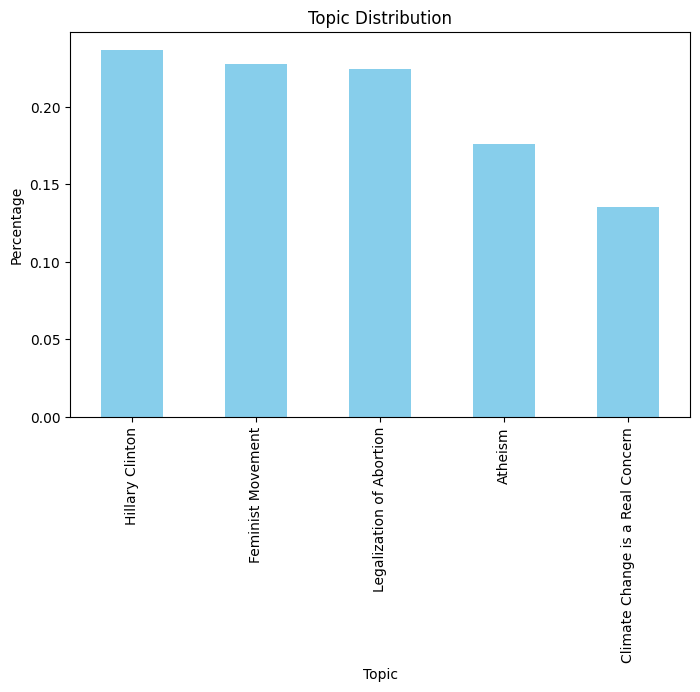

In [15]:
# plot topic distribution
plt.figure(figsize=(8, 5))
topic_distribution.plot(kind='bar', color='skyblue')
plt.title('Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Percentage')
plt.show()

From the above output it looks like Hillary Clinton is a popular topic as most of the tweets we have in our dataset are about this topic. If we take a look at the graph what you notice is there is no major difference in the percentage of tweets for each topic. Yes, climate change just takes up 13% however there is no gross under-representation of a group. Just checking the target topic alone is not sufficient. Ultimately we are determining the Stance for the target topics so we need to see how each stance for a particular target is distributed in the dataset

In [16]:
stance_distribution = train_data.groupby('Target')['Stance'].value_counts(normalize=True)
stance_distribution

Target                            Stance
Atheism                           0         0.592593
                                  2         0.228070
                                  1         0.179337
Climate Change is a Real Concern  1         0.536709
                                  2         0.425316
                                  0         0.037975
Feminist Movement                 0         0.493976
                                  1         0.316265
                                  2         0.189759
Hillary Clinton                   0         0.570392
                                  2         0.258345
                                  1         0.171263
Legalization of Abortion          0         0.543645
                                  2         0.271057
                                  1         0.185299
Name: Stance, dtype: float64

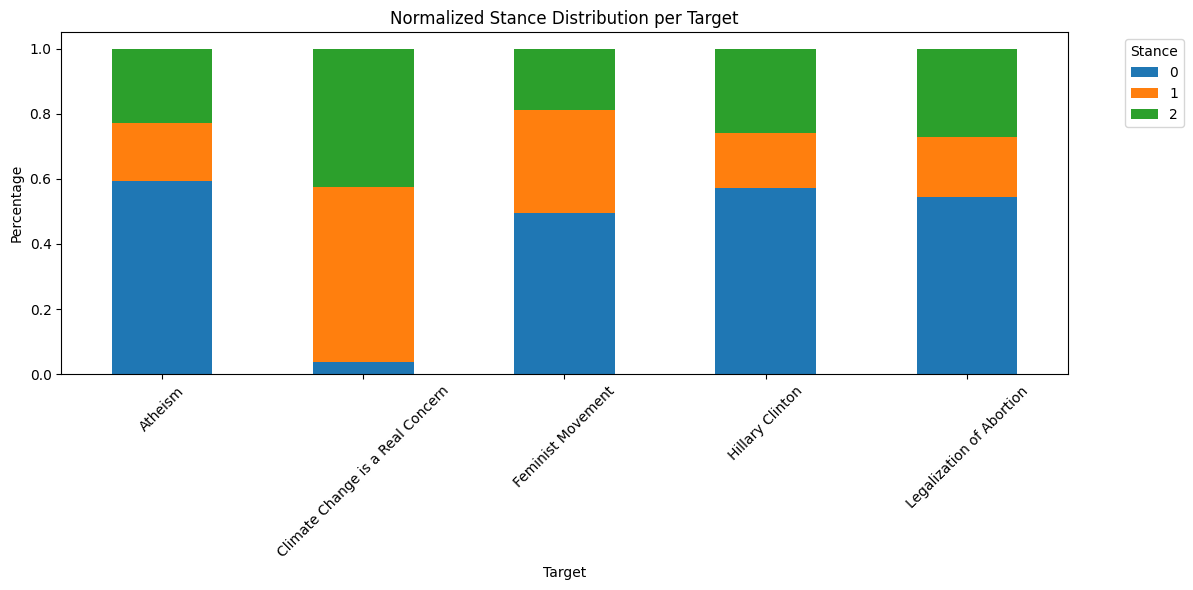

In [17]:
stance_distribution_df = stance_distribution.reset_index(name='Percentage')

# shift the dataframe to have stances as columns and targets as rows
pivot_df = stance_distribution_df.pivot(index='Target', columns='Stance', values='Percentage')

# plot stacked bar chart
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Normalized Stance Distribution per Target')
plt.xlabel('Target')
plt.ylabel('Percentage')
plt.legend(title='Stance', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Please note that 0 is for AGAINST , 1 for FAVOUR and 2 is for NONE.

From the graph we can see that there is an imbalance of data when we consider each Stance for a particular topic. Most of the topics have AGAINST as a majority except for Climate change (which makes sense because very few people will be against climate change). The representation of NONE and FAVOUR is pretty much the same for every group. Its interesting to note that the more controversial the topic the less the number of tweets we have in favour of the topic.

All this points to the fact that the data is imbalanced. A model built on this data may be bad at classifying tweets against Climate Change or classifying tweets in favour of Hillary Clinton. One solution is to get more data for the under represented groups. However this is out of the scope of the assignment. The only thing we can do is ensure that the performance metric that we use to evaluate the model will be able to provide a fair representation of the model's predictive power. The metric shouldnt be dominated by the high number of correct predictions of the majority groups and shadow the minority groups. The metric should accordingly penalise the incorrect predictions of the minority group. Each group should be represented equally.

## Preparing the data

Most Machine learning algorithms require input data to be in numeric form. The input data for our use case are tweets and targets which are both strings. How can we go about representing them in the form of numbers?

Since we know that we are dealing with a fixed number of targets (5 topics) we can treat it as categorical data and encode them (similar to what we did for Stance). But the same cannot be done to tweets as each tweet is independent and represents a different user's view. However one way that text can be represented in numeric form is if each word in the text can be represented as a numeric vector, this is called as word embedding. If we can gather all our tweets and create a vocabulary (which is essentially a list of all the unique words used in the tweets in our dataset) then we can represent each word in the form of a vector is a way that similar words have similar representation and the semantic relationship between words in maintained. This allows machine learning algorithms used for natural language processing tasks to help understand the data better and make accurate predictions.

Now for a given vocabulary, we can train a deep neural network on our dataset and build our own word embeddings via an embedding layer or we can use pre-trained word embeddings such as GloVe. GloVe is a pre-trained word embedding model developed by Stanford that was trained on a large text corpus and has generated word embeddings for pretty much every word in different dimensionalities. These embeddings maintain the sematic relation of words and can thus be used directly in NLP tasks and therefore we need not develop our own embeddings from scratch. In our model we will be using the pre-trained embeddings from GloVe.

Now a pre-requsite of using word embeddings is to ensure the input string being fed into the model is clean, devoid of special characters such as punctuations and any unnecessary words that dont add too much meaning to the sentences such as stop words "the", "and", "is" etc. Therefore we need to pre-process our tweets, remove any words that we deem not meaningful and tokenize them so that we can get a vocabulary. We will also do this same process for the target topics and build its own vocabulary. This is because coverting targets to categorical data as mentioned in the beginning of this section would mean that we loose useful information. The target words often match or are related to the tweet words allowing for a strong association between the two. This association would be lost if we encoded target to categorical data.

First let us clean the text, here we will remove any special characters such as punctuations, hashtags, urls etc all of which are likely to be seen in tweets. We have defined the function `clean_text` for this purpose, it is mainly catered towards cleaning tweets. Below are the steps performed.

1) Remove any urls starting with http/https etc.

2) Find words starting with #. In tweets such words are often used to allow the tweet to get more traction in the platform where popular phrases and trending topics are put with a prefix of hashtag(#). These words may be useful for our task therefore we will not remove them. We will try to split individual words in hashtags into separate words such as #PleaseVote to "please" and "vote". This type of hashtag split will only be done if the hashtag is in CamelCase format where every new word starts with a capital letter. All other hashtags will be treated as one single word.

3) Tweets often have @ symbols which are used to tag other twitter accounts. This has no meaning to us, we dont need account names to understand the sentiment behind the tweet therefore we will remove it.

4) Remove all punctuations.

In [18]:
#Cleaning the tweets
import re

def tokenize_hashtags(text):
    # pattern to match hashtags
    hashtag_pattern = r'#\w+'

    # find all hashtags in the tweet
    hashtags = re.findall(hashtag_pattern, text)

    for hashtag in hashtags:
        # remove the '#' symbol
        words = re.sub(r'#', '', hashtag)
        # CamelCase split
        words = re.sub(r'([a-z0-9])([A-Z])', r'\1 \2', words)
        words = words.split()
        processed_hashtag = ' '.join(words)

        # replace the original hashtag with the new version
        text = text.replace(hashtag, processed_hashtag)

    return text

def clean_text(text):
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # remove mentions
    text = re.sub(r'@\w+', '', text)
    text = tokenize_hashtags(text)

    # remove special characters
    text = re.sub(r'[^a-zA-Z\s\']', ' ', text)
    # handle words with apostrophe
    text = re.sub(r'[\']', '', text)

    # Convert to lowercase
    text = text.lower()

    return text

Let us first clean the tweets.

In [19]:
clean_train_data = train_data.copy()
clean_train_data["Tweet"] = clean_train_data["Tweet"].apply(lambda x: clean_text(x))
clean_train_data.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,and hand over the server she wiped clean ...,Hillary Clinton,0,1. The tweet explicitly expresses opinion abo...,neg
1,hillary is our best choice if we truly want to...,Hillary Clinton,1,1. The tweet explicitly expresses opinion abo...,pos
2,i think our country is ready for a female pre...,Hillary Clinton,0,1. The tweet explicitly expresses opinion abo...,neg
3,i just gave an unhealthy amount of my hard ear...,Hillary Clinton,0,1. The tweet explicitly expresses opinion abo...,neg
4,thank you for adding me to your list,Hillary Clinton,2,3. The tweet is not explicitly expressing opi...,pos


Let us also perform this cleaning on the target. Since target does not have any special notations (#, @) like tweets this function would just remove any punctuations and convert it to lowercase.

In [20]:
clean_train_data["Target"] = clean_train_data["Target"].apply(lambda x: clean_text(x))
clean_train_data.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,and hand over the server she wiped clean ...,hillary clinton,0,1. The tweet explicitly expresses opinion abo...,neg
1,hillary is our best choice if we truly want to...,hillary clinton,1,1. The tweet explicitly expresses opinion abo...,pos
2,i think our country is ready for a female pre...,hillary clinton,0,1. The tweet explicitly expresses opinion abo...,neg
3,i just gave an unhealthy amount of my hard ear...,hillary clinton,0,1. The tweet explicitly expresses opinion abo...,neg
4,thank you for adding me to your list,hillary clinton,2,3. The tweet is not explicitly expressing opi...,pos


Now that we have cleaned the text let us tokenize it. In the below code we've defined a tokenize_text function which takes in a list of text strings where we will perform the following steps:

1) Split the text into words. This will be done using nltk's `word_tokenize`.

2) Remove stopwords such as "and", "the" which has little meaning to the sentence and can be treated as noise. This is also a good way to reduce complexity and keep only meaningful words.

3) Perform Lemmatization. This is the process where words are reduced to their base words. This is done so that we dont have similar words repeated in the vocabulary. For example "jumping" and "jumped" can be reduced to "jump" as they mean the same thing but in different tenses.

4) Remove words with less than 3 characters as often times they do not represent any significant word. This will help reduce noise and complexity.

5) Return a list of tokenized text.

In [21]:
import string
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def tokenize_text(texts):
  clean_texts = list()
  for text in texts:
    # tokenize the text
    tokens = word_tokenize(text)
    # remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    #perform lematization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    #remove words with less than 3 characters
    tokens=[word for word in tokens if len(word)>3]

    clean_texts.append(tokens)
  return clean_texts


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Let us first tokenize the tweets.

In [22]:
tweets = clean_train_data["Tweet"].values.tolist()
clean_tweets = tokenize_text(tweets)

You can see the tokenized form of the first tweet below.

In [23]:
clean_tweets[0]

['hand',
 'server',
 'wiped',
 'clean',
 'deleted',
 'email',
 'explains',
 'dereliction',
 'duty',
 'benghazi',
 'tcot']

Let us also tokenize the target value.

In [24]:
targets = clean_train_data["Target"].values.tolist()
clean_targets = tokenize_text(targets)

In [25]:
clean_targets[0]

['hillary', 'clinton']

Now that we have the tokenized form of the tweets and targets we can go about building the vocabulary for each input. The vocabulary is the total number of unique tokens/words used for an attribute such as tweets or target. We can do this with the help of the `Tokenizer` module in keras. The Tokenizer will read all the tokenised text and generate a vocabulary dictionary where each unique word is given a word index. We can then replace each token with its index. Let us do this first for tweets and then for the target topic.

In [26]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tweet_tokenizer_obj = Tokenizer()
tweet_tokenizer_obj.fit_on_texts(clean_tweets)
sequences = tweet_tokenizer_obj.texts_to_sequences(clean_tweets)

max_length_tweet = max([len(seq) for seq in sequences])

print(max_length_tweet)
tweet_word_index = tweet_tokenizer_obj.word_index
print("unique tokens - "+str(len(tweet_word_index)))
vocab_size = len(tweet_tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))

tweets_pad = pad_sequences(sequences, maxlen=max_length_tweet, padding='post')

15
unique tokens - 6225
vocab_size - 6226


In the above output you can see that there are 6225 unique words in the overall tweet corpus and the maximum tweet length is 15 tokens. In order to ensure all tweets are the same length we have padded tweets with less than 15 tokens with zeros. Let us do the same for target.

In [27]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

target_tokenizer_obj = Tokenizer()
target_tokenizer_obj.fit_on_texts(clean_targets)
sequences = target_tokenizer_obj.texts_to_sequences(clean_targets)

max_length_target = max([len(seq) for seq in sequences])

print(max_length_target)
target_word_index = target_tokenizer_obj.word_index
print("unique tokens - "+str(len(target_word_index)))
vocab_size = len(target_tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))

targets_pad = pad_sequences(sequences, maxlen=max_length_target, padding='post')

4
unique tokens - 11
vocab_size - 12


The target's maximum length is 4 tokens with a vocabulary size of 11.

We now have the each tweet and target represented in the form of token/word indexes rather than the actual word. This can be seen in the below output where the first tweet and its target is represented as word indexes. Notice how the last few numbers are 0, this is because the tweet must be less than 15 tokens and is therefore padded.

In [28]:
print(tweets_pad[0])
print(targets_pad[0])

[ 176  663 2607 1189  775   96 1634 2608  776  157   55    0    0    0
    0]
[1 2 0 0]


This word index representation of the tweets and targets is what is fed into the model and eventually converted to GloVe embeddings in the embedding layer. We will discuss this in the later sections.

## Splitting into train and validation set

Now that we have prepared our data and brought it into the required format we can split it into train and validation sets. The train set will be used to train the model and the validation will be used to assess the model after each training epoch and accordingly fine-tune it. We will use 80% of our `train_data` for training and the remaining 20% on validation. We use more data for training as we want to make sure that our model is able to capture the data patterns and relationships effectively. We also set the `stratify` parameter on the target topics as we want both the train and validation sets to have an equal proportion of observations of different topics. This helps in preventing bias in the splitting process. We also set shuffle to True so that we can randomize the split process and any inherent order in the dataset will be removed.

Below we have the code for splitting the `tweets_pad`, `target_pad` and Stance (which is the variable we are predicting) into train-val sets. Please note the Stance has been converted into one hot encoding where instead of having a single integer represent a class we will have them represented by binary vectors. AGAINST will be [1,0,0], FAVOUR will be [0,1,0] and NONE will be [0,0,1]

In [29]:
from sklearn.model_selection import train_test_split
stance =  clean_train_data['Stance'].values
n_values = np.max(stance) + 1
Y = np.eye(n_values)[stance]

X_train_tweet, X_val_tweet, X_train_target, X_val_target,X_train_tclass,X_val_tclass,X_train_sclass,X_val_sclass, y_train_stance, y_val_stance = train_test_split(
    tweets_pad, targets_pad, clean_train_data['Target'],clean_train_data['Stance'], Y, test_size=0.2 , stratify=clean_train_data['Target'], shuffle=True
)

In [30]:
print('Shape of X_train_tweet:', X_train_tweet.shape)
print('Shape of X_train_target:', X_train_target.shape)
print('Shape of y_train_stance:', y_train_stance.shape)

print('Shape of X_val_tweet:', X_val_tweet.shape)
print('Shape of X_val_target:', X_val_target.shape)
print('Shape of y_val_stance:', y_val_stance.shape)

Shape of X_train_tweet: (2331, 15)
Shape of X_train_target: (2331, 4)
Shape of y_train_stance: (2331, 3)
Shape of X_val_tweet: (583, 15)
Shape of X_val_target: (583, 4)
Shape of y_val_stance: (583, 3)


From the above output we know that the train set has 2331 observations and the validation set has 583.

When we split the dataset we ensured that the proportion of the target topics in the train and validation sets are equal, let us also check if the proportion of the stances per target is same in both train and validation set.

In [31]:
train_split = {'Target': X_train_tclass, 'Stance': X_train_sclass}
train_split = pd.DataFrame(train_split)

stance_distribution = train_split.groupby('Target')['Stance'].value_counts(normalize=True)
stance_distribution

Target                            Stance
atheism                           0         0.593674
                                  2         0.214112
                                  1         0.192214
climate change is a real concern  1         0.528481
                                  2         0.439873
                                  0         0.031646
feminist movement                 0         0.493409
                                  1         0.325800
                                  2         0.180791
hillary clinton                   0         0.562613
                                  2         0.261343
                                  1         0.176044
legalization of abortion          0         0.545977
                                  2         0.277778
                                  1         0.176245
Name: Stance, dtype: float64

In [32]:
val_split = {'Target': X_val_tclass, 'Stance': X_val_sclass}
val_split = pd.DataFrame(val_split)

stance_distribution = val_split.groupby('Target')['Stance'].value_counts(normalize=True)
stance_distribution

Target                            Stance
atheism                           0         0.588235
                                  2         0.284314
                                  1         0.127451
climate change is a real concern  1         0.569620
                                  2         0.367089
                                  0         0.063291
feminist movement                 0         0.496241
                                  1         0.278195
                                  2         0.225564
hillary clinton                   0         0.601449
                                  2         0.246377
                                  1         0.152174
legalization of abortion          0         0.534351
                                  2         0.244275
                                  1         0.221374
Name: Stance, dtype: float64

From the above output we can see that roughly the proportion of stances per topic is pretty much the same in train and validation sets. This is good to check as when we are evaluating the model we want to make sure that validation is representative of the training set so that the validation measure is not dominated by majority class. This allows for a fair validation process.

## Pre-Trained GloVe embedding

As discussed in the previous section we will be using GloVe pre-trained word embeddings to represent our input in the vector space. In GloVe the model was trained on a large text corpus and therefore it has the vector representations for a large number number of words. These embeddings maintain the semantic relationship between words which will help our model in understanding the meaning behind our input text and accordingly detect the stance.

The GloVe embeddings are available in the form of a file where each line has the vector representation of a particular word. The embeddings are available in different dimensions i.e vector length such as 50, 100, 200 etc. The higher the dimension value the better the representation but also the greater the complexity. I decided to go with a 100 dimension GloVe embedding as computationally this would be the most feasible option without compromising on the word representation.

We have downloaded the embeddings from the Stanford website. Let us load this into our workspace.

In [33]:
!cp /content/drive/'My Drive'/COSC2779/A2/glove.6B.100d.txt .

We will read each line of the file and create a dictionary where the key is the word and the value is the vector representation of that word.

In [34]:
file = open('glove.6B.100d.txt', encoding='utf-8')

glove_vectors = dict()
for line in file:
  values = line.split()
  word = values[0]
  features = np.asarray(values[1:])
  glove_vectors[word] = features

file.close()

Now that we have loaded the GloVe embeddings we can now create an embedding matrix for our tweet and target input. This matrix will have the GloVe embedding for the words in the input vocabulary. For the words in the vocabulary that are not in the GloVe dictionary the vector representation will be 0.

Let us first create the embedding matrix for our tweets.

In [35]:
embedding_dim = 100
E_Tweet = np.zeros((len(tweet_word_index) + 1, embedding_dim))
for word, i in tweet_word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        E_Tweet[i] = embedding_vector

In [36]:
E_Tweet[1]

array([ 0.59368 ,  0.44825 ,  0.5932  ,  0.074134,  0.11141 ,  1.2793  ,
        0.16656 ,  0.2407  ,  0.39045 ,  0.32766 , -0.75034 ,  0.35007 ,
        0.76057 ,  0.38067 ,  0.17517 ,  0.031791,  0.46849 , -0.21653 ,
       -0.46282 ,  0.39967 ,  0.16623 , -0.011477,  0.044059,  0.30325 ,
        0.6153  ,  0.47047 , -0.44036 , -1.5963  ,  0.18433 ,  0.23193 ,
        0.20452 ,  0.51617 ,  0.65734 , -0.3452  ,  0.23446 , -0.62004 ,
       -0.68741 ,  0.28575 ,  1.0605  ,  0.46916 , -0.85149 ,  0.10154 ,
        0.21426 , -0.20587 ,  0.23636 ,  0.21321 , -0.21287 ,  0.12107 ,
        0.18766 , -0.23282 , -0.25499 , -0.39631 ,  0.84379 ,  1.6801  ,
       -0.40941 , -1.9976  , -0.69868 ,  0.21732 ,  1.2197  ,  0.55126 ,
        0.44095 ,  0.72588 , -0.092053, -0.022406,  0.72039 ,  0.1076  ,
        0.84116 ,  0.30312 , -0.42544 ,  0.056362,  0.13109 , -0.071181,
       -0.10579 ,  0.56677 ,  0.54547 ,  0.84113 ,  0.14861 , -0.62628 ,
       -0.68391 , -1.0831  , -0.088385,  0.32167 , 

The above output is the GloVe embedding of the first word in the tweet vocabulary which happens to be "woman".
Let us create the embedding matrix for target.

In [37]:
embedding_dim = 100
E_Target = np.zeros((len(target_word_index) + 1, embedding_dim))
for word, i in target_word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        E_Target[i] = embedding_vector

Now that our embedding matrices are ready we can proceed with building our base stance detection model.

## Model Building

Our goal is to build a multi class classification model which will take in two inputs - Tweet and Target topic - and predict whether the tweet is against, in favour of or neutral towards the target topic. Before we set up the model architecture let us define some of the initial parameters that are needed to build the model.

First we will define the callback function, this function is called after every epoch to update the Tensor board. This will help us keep track of the training process. We will also keep a history dictionary which for every model we train it will store the loss and preformance metric values for each epoch for the train and validation data.

In [38]:
def get_callbacks(name):
  return [
    tf.keras.callbacks.TensorBoard(logdir/name, histogram_freq=1),
  ]

m_histories={}

Next we will define the epoch and batch size. The epoch is the number of times the model will go through the training dataset during the training process. In our case we will train the model for 50 epochs. We picked 50 because our dataset is limited so 50 epochs should be sufficient for the model to learn from the data and converge. Also given the small size of the dataset the complexity of our model will be less (to prevent overfitting) which justifies the choice of a smaller epoch number.

I decided to go with a batch size of 32. Batch size is the number of observations fed to the model after which the weights are updated. 32 is a good base batch size, it works well with memory and computation time, models trained with smaller batch sizes are said to generalize well on unseen data because of the noise it introduces. Also since our dataset is small, a smaller batch size allows for the weights to be updated more number of times which will help the model learn better.

In [39]:
EPOCH=50
BATCH_SIZE=32

I set a learning rate of 0.001 for my model. I started with a low learning rate because i didnt want the model to converge to a optimal solution without skipping over the global minima which is what would have happened if we hada high learning rate. A higher learning rate would also suppress our network because of the small dataset and lead to overfitting very quickly. As the training process progresses we will decrease the learning rate by a factor of 0.1 this will ensure that the model makes good progress in the beginning by skipping local minima but then slows down and stabilises in the later stage. We will be reducing the learning rate exponentially over time.

You can see the decay curve in the below output.

In [40]:
from tensorflow.keras.optimizers.legacy import Adam

STEPS_PER_EPOCH = X_train_tweet.shape[0]//32
lr = 0.001

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  lr,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=0.1,
  staircase=False)


Text(0.5, 1.0, 'Learning rate decay')

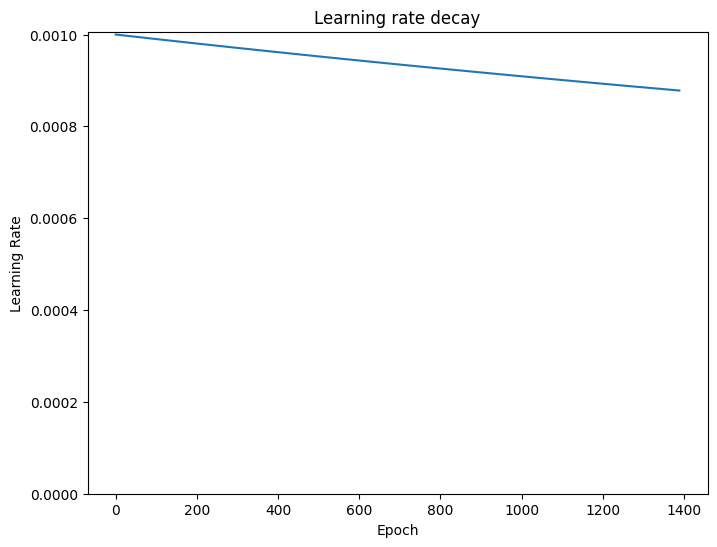

In [41]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title("Learning rate decay")

We will be using Adam optimizer for our model. Adam is an optimzer that is popular for its adaptive learning rate and quick convergence. It is known to converge to a good solution faster than other optimizers. This is beneficial for us as we have less data to train the model so the quicker we find an optimal solution the lesser time (epochs) we will need to spend training the model which in turn will help prevent overfitting.

In [42]:
optimizer = Adam(learning_rate=lr_schedule)

## Model Architecture

In this section we will build our base model and go through each layer of the model and why we picked it. The code below has the definition of the RNN model we will be using for Stance detection.

The model will first have two input layers. One layer is for the tweet input and the other for target. The input will be in the form of integers representing words and the maximum length of each input type is 15 and 4 which was determined during the tokenization process. Now each input type will go through different type of processing before they are combined. Both input will be fed into a separate embedding layer. The embedding layer converts the word integers to word embeddings (dense vector representations) using the pre-trained GloVe embeddings we had loaded earlier. Note that each embedding layer has the embedding matrix we had created previously for tweet and target. The `trainable` parameter has been set to False. This means that we will be using the weights of the pre-trained embeddings and this will not change through out the process. This type of direct use of pre-trained weights from a different model in our model is called Transfer Learning.

Post the Embedding layer the tweet input data will be fed into an LSTM layer. This is called Long Short Term Memory layer and it is a type of recurrent neural network that captures long range dependencies in sequential data i.e text. I decided to go with LSTM over other RNNs such as GRU because of the fact that it can store information over long ranges of the sequential data which will allow it to understand the meaning of tweets and hopefully gauge complex text patterns better than GRU which maintains only short term dependencies. I went with 32 units and a 0.5 drop out and 0.3 recurrent dropout as i didnt want the LSTM capacity to be too high because it is already a complex network and I also wanted to adress overfitting.

As for the target input, post embedding layer it will be sent into a Dense layer of 32 units followed by a dropout of 50%. We do not pass it to a LSTM layer like tweets as we have a fixed number of target topics so there are only 5 different sequences that will be seen for this input type. We want to preserve the word information but we dont really need it to learn word dependencies using LSTM. Therefore we pass it to a fully connected layer to learn patterns.

The outputs of both the LSTM  and fully connected layer of tweet and target input are then combined by the Concatenate layer to give us a single representation. This will then be fed into a Flatten layer which will convert it into a 1 dimensional tensor which can easily fed into a fully connected layer. We pass this flattened representation to a Dense layer with 64 units, we do this to try to allow the model to learn complex patterns of the LSTM output. The activation we used is the default "relu", I went ahead with this because relu allows for quick convergence without overfitting, which is ideal for our small dataset. It is also computationally efficient. We will also add a dropout after the dense layer where 50% of the units will be dropped, this is to keep a check on overfitting.

Post this the data will finally be fed into the output layer. We have 3 units defined for the 3 classes we are trying to predict. The activation is softmax because it will give us a probability of likelihood of each class with one being the most likely which is what we need for our usecase.

In [43]:
from tensorflow.keras.layers import Dense, Embedding, LSTM,Input,concatenate,Flatten,Dropout
from tensorflow.keras.models import Model

tf.keras.backend.clear_session()

tweet_input = Input(shape=(max_length_tweet,))
target_input = Input(shape=(max_length_target,))

tweet_embedding = Embedding(len(tweet_word_index) + 1,
                            embedding_dim,
                            weights=[E_Tweet],
                            input_length=max_length_tweet,
                            trainable=False)(tweet_input)

lstm_tweet = LSTM(32,dropout=0.5, recurrent_dropout=0.3)(tweet_embedding)

target_embedding = Embedding(len(target_word_index) + 1,
                            embedding_dim,
                            weights=[E_Target],
                            input_length=max_length_target,
                            trainable=False)(target_input)

dense_target = Dense(units=32, activation='relu')(target_embedding)

dense_target = Dropout(0.5)(dense_target)

dense_target = Flatten()(dense_target)

concatenated = concatenate([lstm_tweet, dense_target])

flatten_layer = Flatten()(concatenated)

dense_layer = Dense(units=64, activation='relu')(flatten_layer)

dense_layer = Dropout(0.5)(dense_layer)

output_layer = Dense(3, activation='softmax')(dense_layer)

model = Model(inputs=[tweet_input, target_input], outputs=output_layer)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 4, 100)               1200      ['input_2[0][0]']             
                                                                                                  
 input_1 (InputLayer)        [(None, 15)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 4, 32)                3232      ['embedding_1[0][0]']         
                                                                                              

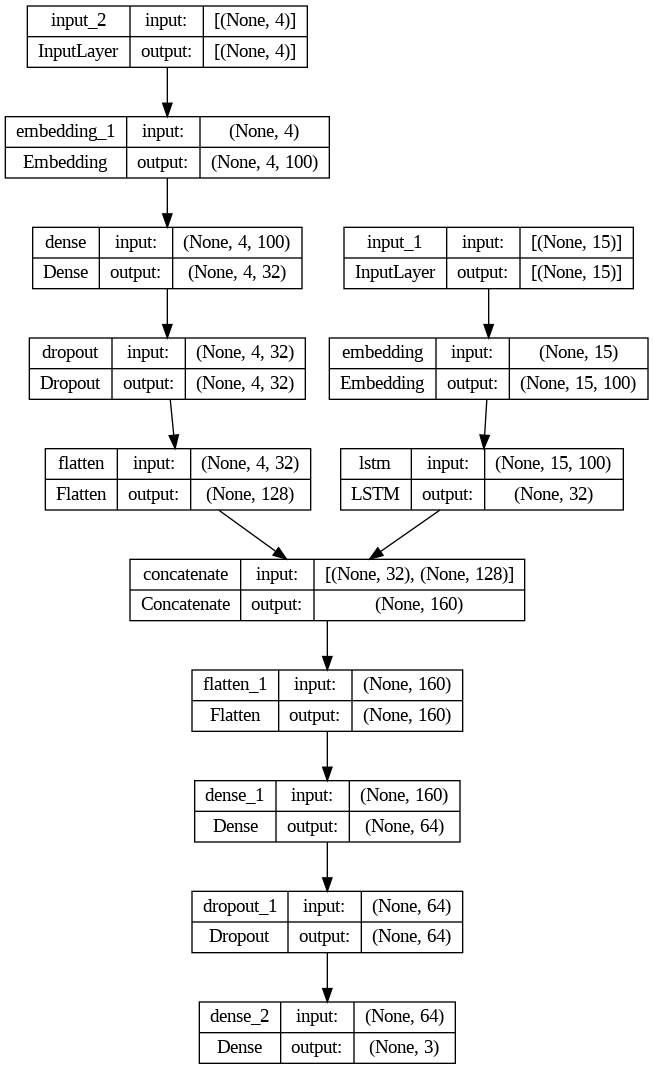

In [44]:
tf.keras.utils.plot_model( model, to_file='model.png', show_shapes=True)

You can see the model layout above, how the two input branches merge to a fully connected layer and provide the output. Now let us compile the model, for this we need to define the metrics and loss function. The loss function for our model is categorical_crossentropy as this is a multi class classification problem where only one class is the true class and the output values are fed as one-hot encoded vectors. The metric we will monitor is primarliy f1-score. We will also keep an eye on categorical accuracy just to see how it fares. As discussed before there is a slight imbalance in the data for each target and stance pair. Therefore want to consider a metric where each class is given equal importance and where a model's performance measure isnt dominated by a majority class. This is why we will consider f1-score when evaluating a model's performance. Since we have a multi-class classification process we will be calculating the f1-score for each class and taking the average (macro). Macro avergae does not use weights, so when the model has a poor F1-Score for a minority class it accordingly penalises it when calculating the overall F1-Score

F1-score is not inherently available in the keras package so we will use F1-Score provided in the tensorflow addons package.

In [45]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Let us now compile the model and start the training process.

In [46]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[tfa.metrics.F1Score(average='macro',num_classes=3),'categorical_accuracy'])
m_histories['base'] = model.fit([X_train_tweet, X_train_target],np.array(y_train_stance),
                                validation_data=([X_val_tweet, X_val_target],np.array(y_val_stance)),batch_size=BATCH_SIZE, epochs=EPOCH, callbacks=get_callbacks('models/base'), verbose=1)

Epoch 1/50
73/73 [==============================] - 11s 87ms/step - loss: 1.0415 - f1_score: 0.3746 - categorical_accuracy: 0.4801 - val_loss: 0.9692 - val_f1_score: 0.3700 - val_categorical_accuracy: 0.5557
Epoch 2/50
73/73 [==============================] - 4s 55ms/step - loss: 0.9901 - f1_score: 0.3786 - categorical_accuracy: 0.5320 - val_loss: 0.9667 - val_f1_score: 0.3700 - val_categorical_accuracy: 0.5557
Epoch 3/50
73/73 [==============================] - 4s 60ms/step - loss: 0.9627 - f1_score: 0.3952 - categorical_accuracy: 0.5367 - val_loss: 0.9327 - val_f1_score: 0.4011 - val_categorical_accuracy: 0.5626
Epoch 4/50
73/73 [==============================] - 6s 82ms/step - loss: 0.9365 - f1_score: 0.4224 - categorical_accuracy: 0.5435 - val_loss: 0.9021 - val_f1_score: 0.4080 - val_categorical_accuracy: 0.5678
Epoch 5/50
73/73 [==============================] - 5s 74ms/step - loss: 0.9348 - f1_score: 0.4455 - categorical_accuracy: 0.5504 - val_loss: 0.9237 - val_f1_score: 0.4793

Lets plot the loss metrics to see how the model is learning.

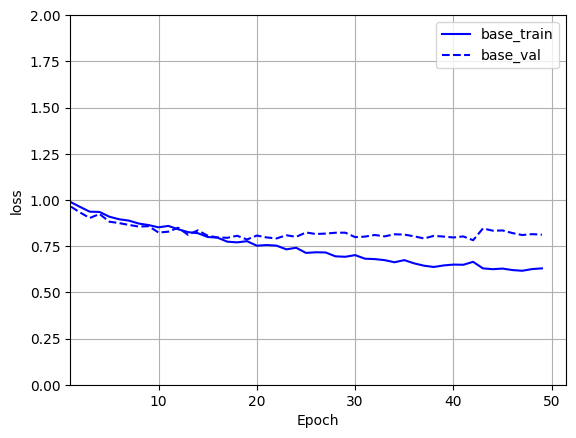

In [47]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

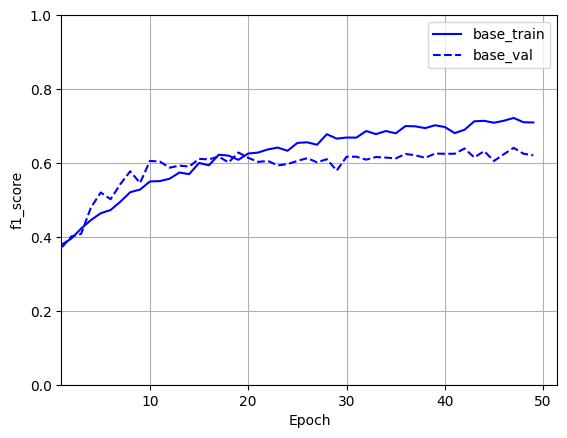

In [48]:
plotter(m_histories, ylim=[0.0, 1], metric = 'f1_score')

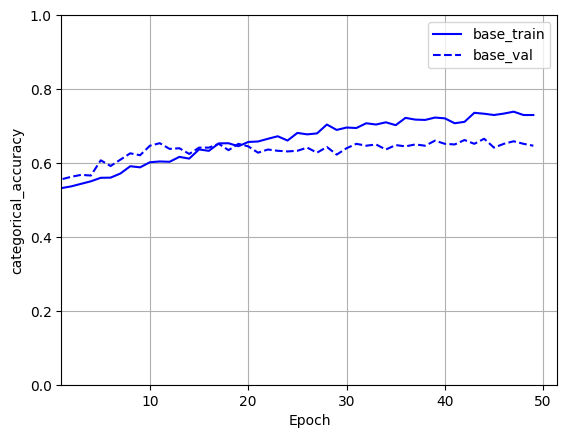

In [49]:
plotter(m_histories, ylim=[0.0, 1], metric = 'categorical_accuracy')

From the looks of the graph it is very clear that there is an overfitting problem. With each epoch you can see that the training performance of the model increases but the validation performance decrease indicating poor generalization. In order to address this let us increase the regularization measures taken previously. I will increase the LSTM dropouts by one factor and the dropout of the fully connected layer to 0.8. 0.8 is a high dropout percentage, in order to not compromise on the learning capability I will add another Dense-Dropout layer pair in the fully connected network. I will also add L2 regularisation of 0.01 strength to the Dense layers as this will help keep the weights in check and keep them small and controlled which avoids overfitting.

In [50]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional,Input,concatenate,Flatten,Dropout
from tensorflow.keras.models import Model

tf.keras.backend.clear_session()

tweet_input = Input(shape=(max_length_tweet,))
target_input = Input(shape=(max_length_target,))

tweet_embedding = Embedding(len(tweet_word_index) + 1,
                            embedding_dim,
                            weights=[E_Tweet],
                            input_length=max_length_tweet,
                            trainable=False)(tweet_input)

lstm_tweet = LSTM(32,dropout=0.6, recurrent_dropout=0.4)(tweet_embedding)

target_embedding = Embedding(len(target_word_index) + 1,
                            embedding_dim,
                            weights=[E_Target],
                            input_length=max_length_target,
                            trainable=False)(target_input)

dense_target = Dense(units=32, activation='relu')(target_embedding)

dense_target = Dropout(0.6)(dense_target)

dense_target = Flatten()(dense_target)

concatenated = concatenate([lstm_tweet, dense_target])

flatten_layer = Flatten()(concatenated)

dense_layer = Dense(units=64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(flatten_layer)

dense_layer = Dropout(0.8)(dense_layer)

dense_layer = Dense(units=64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(flatten_layer)

dense_layer = Dropout(0.8)(dense_layer)

output_layer = Dense(3, activation='softmax')(dense_layer)

model = Model(inputs=[tweet_input, target_input], outputs=output_layer)


In [51]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[tfa.metrics.F1Score(average='macro',num_classes=3),'categorical_accuracy'])
m_histories['tune1'] = model.fit([X_train_tweet, X_train_target],np.array(y_train_stance),
                                validation_data=([X_val_tweet, X_val_target],np.array(y_val_stance)),batch_size=BATCH_SIZE, epochs=EPOCH, callbacks=get_callbacks('models/tune1'), verbose=1)

Epoch 1/50
73/73 [==============================] - 7s 45ms/step - loss: 1.3110 - f1_score: 0.3782 - categorical_accuracy: 0.5066 - val_loss: 1.0612 - val_f1_score: 0.3700 - val_categorical_accuracy: 0.5557
Epoch 2/50
73/73 [==============================] - 5s 69ms/step - loss: 1.0671 - f1_score: 0.3526 - categorical_accuracy: 0.5277 - val_loss: 0.9985 - val_f1_score: 0.3700 - val_categorical_accuracy: 0.5557
Epoch 3/50
73/73 [==============================] - 5s 62ms/step - loss: 1.0170 - f1_score: 0.3582 - categorical_accuracy: 0.5332 - val_loss: 0.9736 - val_f1_score: 0.3190 - val_categorical_accuracy: 0.5283
Epoch 4/50
73/73 [==============================] - 5s 64ms/step - loss: 1.0036 - f1_score: 0.3722 - categorical_accuracy: 0.5401 - val_loss: 0.9557 - val_f1_score: 0.3700 - val_categorical_accuracy: 0.5557
Epoch 5/50
73/73 [==============================] - 5s 74ms/step - loss: 0.9901 - f1_score: 0.3565 - categorical_accuracy: 0.5285 - val_loss: 0.9483 - val_f1_score: 0.3700 

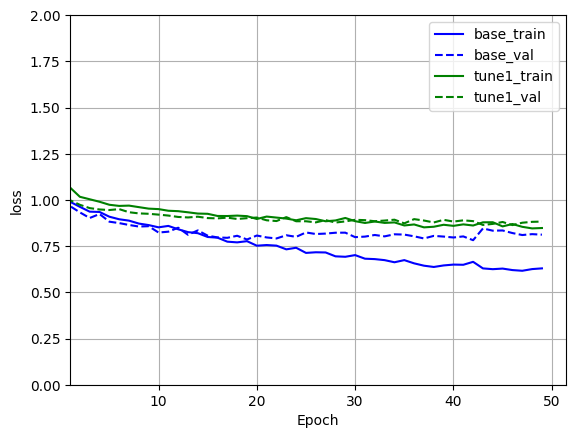

In [52]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

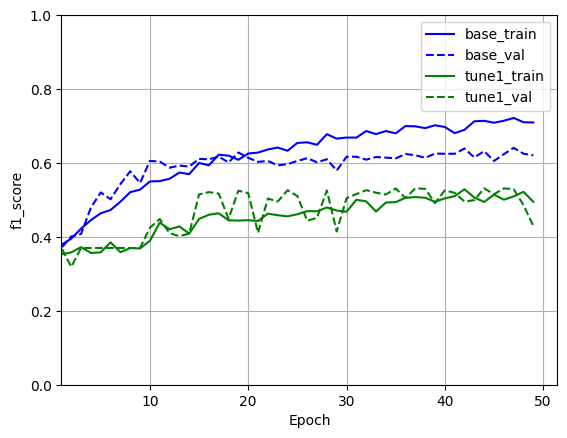

In [53]:
plotter(m_histories, ylim=[0.0, 1], metric = 'f1_score')

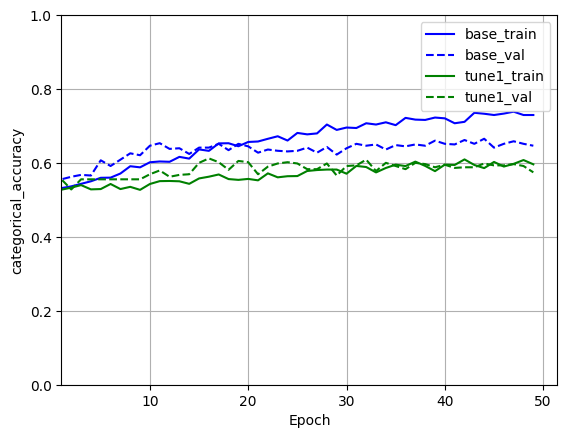

In [54]:
plotter(m_histories, ylim=[0.0, 1], metric = 'categorical_accuracy')

You can now see from the graphs that increasing the regularization methods helped reduce overfitting. The loss and metrics curves both have train and validation values at around the same range as the epoch increases.

In the current model we have a categorical accuracy and f1-score in the range of 0.5 to 0.55. This shows that the model's capability to detect stance is just average and not very good. Let us see if we can tune some parameters and adjust model architecture to see if we can improve the performance.

I decided to add an Attention layer that takes the LSTM outputs of tweets and performs self attention. This attentention layer allows the model to focus on specific parts of the sequence outputs and pay more importance to it, kind of like human attention. `tweet_attention` represents the attention weights calculated over different parts of the sequence which is then applied to the LSTM states to get `tweet_context` where different weight of importance is given to different parts of the input tweet. This mechanism along with LSTM allows the model to pick up on subtle text patterns and capturing dependencies within the text. The `tweet_context` will then be Flattened and concatenated along with the original LSTM output of tweets and the Dense layer output of target.

In [55]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional,Input,concatenate,Flatten,Dropout,Attention
from tensorflow.keras.models import Model

tf.keras.backend.clear_session()

tweet_input = Input(shape=(max_length_tweet,))
target_input = Input(shape=(max_length_target,))

tweet_embedding = Embedding(len(tweet_word_index) + 1,
                            embedding_dim,
                            weights=[E_Tweet],
                            input_length=max_length_tweet,
                            trainable=False)(tweet_input)

lstm_tweet = LSTM(32,dropout=0.6, recurrent_dropout=0.4)(tweet_embedding)

tweet_attention = Attention()([lstm_tweet, lstm_tweet])

tweet_context = tf.reduce_sum(tweet_attention * lstm_tweet, axis=1)

tweet_context = Flatten()(tweet_context)

target_embedding = Embedding(len(target_word_index) + 1,
                            embedding_dim,
                            weights=[E_Target],
                            input_length=max_length_target,
                            trainable=False)(target_input)

dense_target = Dense(units=32, activation='relu')(target_embedding)

dense_target = Dropout(0.5)(dense_target)

dense_target = Flatten()(dense_target)

concatenated = concatenate([lstm_tweet, dense_target, tweet_context])

flatten_layer = Flatten()(concatenated)

dense_layer = Dense(units=64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(flatten_layer)

dense_layer = Dropout(0.8)(dense_layer)

dense_layer = Dense(units=64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(flatten_layer)

dense_layer = Dropout(0.8)(dense_layer)

output_layer = Dense(3, activation='softmax')(dense_layer)

model = Model(inputs=[tweet_input, target_input], outputs=output_layer)


In [56]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[tfa.metrics.F1Score(average='macro',num_classes=3),'categorical_accuracy'])
m_histories['tune2'] = model.fit([X_train_tweet, X_train_target],np.array(y_train_stance),
                                validation_data=([X_val_tweet, X_val_target],np.array(y_val_stance)),batch_size=BATCH_SIZE, epochs=EPOCH, callbacks=get_callbacks('models/tune2'), verbose=1)

Epoch 1/50
73/73 [==============================] - 8s 48ms/step - loss: 1.3154 - f1_score: 0.3615 - categorical_accuracy: 0.4925 - val_loss: 1.0551 - val_f1_score: 0.3190 - val_categorical_accuracy: 0.5283
Epoch 2/50
73/73 [==============================] - 3s 41ms/step - loss: 1.0582 - f1_score: 0.3642 - categorical_accuracy: 0.5363 - val_loss: 1.0056 - val_f1_score: 0.3700 - val_categorical_accuracy: 0.5557
Epoch 3/50
73/73 [==============================] - 2s 27ms/step - loss: 1.0143 - f1_score: 0.3672 - categorical_accuracy: 0.5354 - val_loss: 0.9784 - val_f1_score: 0.3700 - val_categorical_accuracy: 0.5557
Epoch 4/50
73/73 [==============================] - 2s 27ms/step - loss: 0.9922 - f1_score: 0.3447 - categorical_accuracy: 0.5268 - val_loss: 0.9645 - val_f1_score: 0.3700 - val_categorical_accuracy: 0.5557
Epoch 5/50
73/73 [==============================] - 2s 27ms/step - loss: 0.9870 - f1_score: 0.3527 - categorical_accuracy: 0.5311 - val_loss: 0.9604 - val_f1_score: 0.3700 

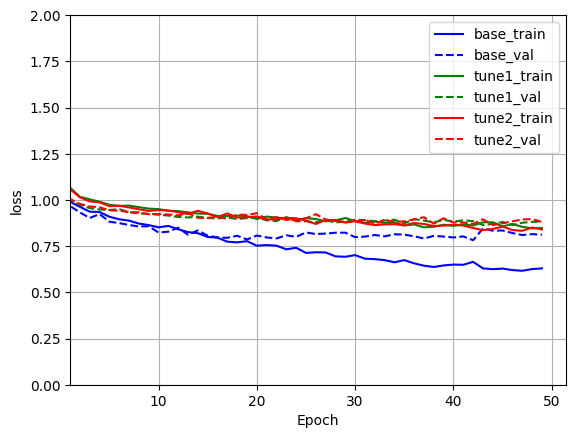

In [57]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

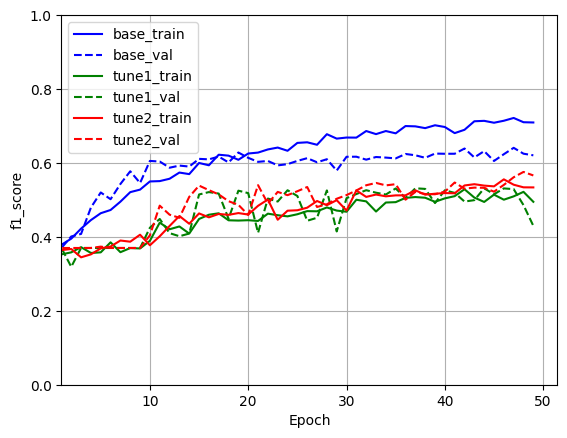

In [58]:
plotter(m_histories, ylim=[0.0, 1], metric = 'f1_score')

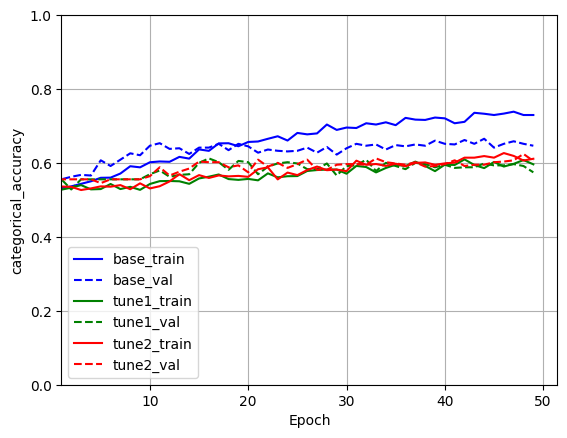

In [59]:
plotter(m_histories, ylim=[0.0, 1], metric = 'categorical_accuracy')

From the above output it looks like the addition of Attention layer provided pretty much the same results as what was seen before. There isnt too much of an improvement. There are multiple different outputs from different activations being combined, I feel that if we can normalize the data so that the model deals with a standardised form, it may help improve its performance.

 I then decided to include a BatchNormalization layer after concatenate and every Dense layer. BatchNormalization stabilises the model by normalising the activations of the previous layer. It allows for quicker convergence and generalisation. Since in concatenation we are combining the outputs of multiple different layers with different activation distributions so normalising the output before feeding it to the fully connected layer will help the model process the data better.

Let us see the models performance with BatchNorm.

In [60]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional,Input,concatenate,Flatten,Dropout,Attention,BatchNormalization
from tensorflow.keras.models import Model

tf.keras.backend.clear_session()

tweet_input = Input(shape=(max_length_tweet,))
target_input = Input(shape=(max_length_target,))

tweet_embedding = Embedding(len(tweet_word_index) + 1,
                            embedding_dim,
                            weights=[E_Tweet],
                            input_length=max_length_tweet,
                            trainable=False)(tweet_input)

lstm_tweet = LSTM(32,dropout=0.6, recurrent_dropout=0.4)(tweet_embedding)

tweet_attention = Attention()([lstm_tweet, lstm_tweet])

tweet_context = tf.reduce_sum(tweet_attention * lstm_tweet, axis=1)

tweet_context = Flatten()(tweet_context)

target_embedding = Embedding(len(target_word_index) + 1,
                            embedding_dim,
                            weights=[E_Target],
                            input_length=max_length_target,
                            trainable=False)(target_input)

dense_target = Dense(units=32, activation='relu')(target_embedding)

dense_target = Dropout(0.5)(dense_target)

dense_target = Flatten()(dense_target)

concatenated = concatenate([lstm_tweet, dense_target, tweet_context])

batch_normalized = BatchNormalization()(concatenated)

flatten_layer = Flatten()(batch_normalized)

dense_layer = Dense(units=64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(flatten_layer)

dense_layer = BatchNormalization()(dense_layer)

dense_layer = Dropout(0.8)(dense_layer)

dense_layer = Dense(units=64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(flatten_layer)

dense_layer = BatchNormalization()(dense_layer)

dense_layer = Dropout(0.8)(dense_layer)

output_layer = Dense(3, activation='softmax')(dense_layer)

model = Model(inputs=[tweet_input, target_input], outputs=output_layer)


In [61]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[tfa.metrics.F1Score(average='macro',num_classes=3),'categorical_accuracy'])
m_histories['tune3'] = model.fit([X_train_tweet, X_train_target],np.array(y_train_stance),
                                validation_data=([X_val_tweet, X_val_target],np.array(y_val_stance)),batch_size=BATCH_SIZE, epochs=EPOCH, callbacks=get_callbacks('models/tune3'), verbose=1)

Epoch 1/50
73/73 [==============================] - 8s 39ms/step - loss: 2.4331 - f1_score: 0.3732 - categorical_accuracy: 0.4196 - val_loss: 1.5443 - val_f1_score: 0.3718 - val_categorical_accuracy: 0.5455
Epoch 2/50
73/73 [==============================] - 3s 38ms/step - loss: 1.6034 - f1_score: 0.3795 - categorical_accuracy: 0.4693 - val_loss: 1.3916 - val_f1_score: 0.3700 - val_categorical_accuracy: 0.5557
Epoch 3/50
73/73 [==============================] - 3s 47ms/step - loss: 1.3865 - f1_score: 0.4128 - categorical_accuracy: 0.5157 - val_loss: 1.2959 - val_f1_score: 0.3288 - val_categorical_accuracy: 0.5317
Epoch 4/50
73/73 [==============================] - 2s 29ms/step - loss: 1.2993 - f1_score: 0.3886 - categorical_accuracy: 0.5174 - val_loss: 1.2136 - val_f1_score: 0.3700 - val_categorical_accuracy: 0.5557
Epoch 5/50
73/73 [==============================] - 2s 30ms/step - loss: 1.1976 - f1_score: 0.4087 - categorical_accuracy: 0.5393 - val_loss: 1.1563 - val_f1_score: 0.3700 

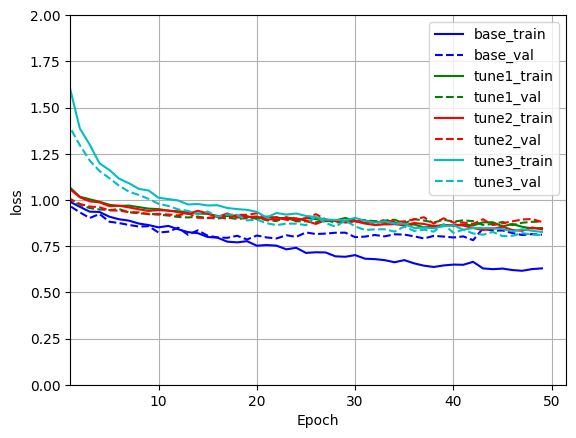

In [62]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

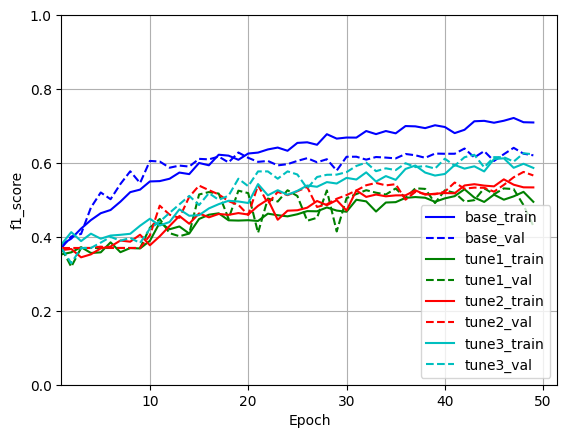

In [63]:
plotter(m_histories, ylim=[0.0, 1], metric = 'f1_score')

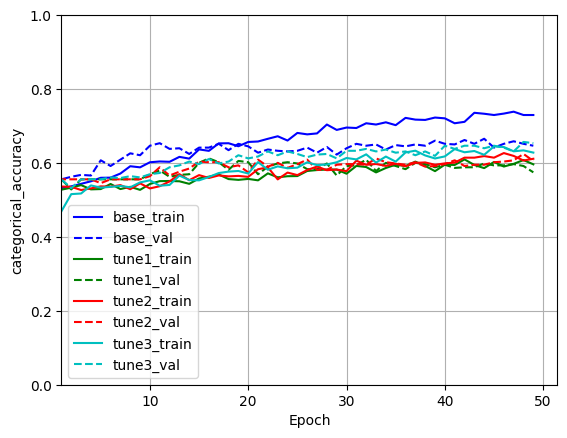

In [64]:
plotter(m_histories, ylim=[0.0, 1], metric = 'categorical_accuracy')

We can see that the combination of BatchNormalization along with self attention works well and that the performance has improved. The loss curve for the latest model is slightly lower than the previous model and we can also see an improvement in F1-Score and accuracy. F1-Score is now around 0.6.

I feel that any further addition to model may make it too complex and lead to overfitting. I think with the data that we have at hand this is the best that can be done and the only way to increase the performance now would be to add more data. With more data the model can learn more patterns efficiently, it'll be able to understand the nuances of the text and generalise well on unseen data. Since getting more data is out of the scope of this assignment we can stop the tuning process here and finalise the model.

## Model Performance evaluation

Now that we have our final model we can test the performance of the model on the test data that we had loaded in the begining of the notebook.

In [65]:
test_data.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; a...,Atheism,0,1. The tweet explicitly expresses opinion abo...,pos
1,RT @prayerbullets: I remove Nehushtan -previou...,Atheism,0,1. The tweet explicitly expresses opinion abo...,other
2,@Brainman365 @heidtjj @BenjaminLives I have so...,Atheism,0,1. The tweet explicitly expresses opinion abo...,pos
3,#God is utterly powerless without Human interv...,Atheism,0,1. The tweet explicitly expresses opinion abo...,neg
4,@David_Cameron Miracles of #Multiculturalism...,Atheism,0,2. The tweet does NOT expresses opinion about ...,neg


In [66]:
test_data.shape

(1249, 5)

Just like how the training data was cleaned, tokenised and converted into integer representation before being fed into the model, we need to perform the same steps on the test data before it can be used for evaluating the model performance.

In [67]:
clean_test_data = test_data.copy()
clean_test_data["Tweet"] = clean_test_data["Tweet"].apply(lambda x: clean_text(x))
clean_test_data["Target"] = clean_test_data["Target"].apply(lambda x: clean_text(x))
clean_test_data.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,he who exalts himself shall be humbled a...,atheism,0,1. The tweet explicitly expresses opinion abo...,pos
1,rt i remove nehushtan previous moves of god...,atheism,0,1. The tweet explicitly expresses opinion abo...,other
2,i have sought the truth of my soul and foun...,atheism,0,1. The tweet explicitly expresses opinion abo...,pos
3,god is utterly powerless without human interve...,atheism,0,1. The tweet explicitly expresses opinion abo...,neg
4,miracles of multiculturalism miracles of ...,atheism,0,2. The tweet does NOT expresses opinion about ...,neg


In [68]:
# Tokenization of test data
tweets = clean_test_data["Tweet"].values.tolist()
clean_test_tweets = tokenize_text(tweets)

targets = clean_test_data["Target"].values.tolist()
clean_test_targets = tokenize_text(targets)

In the above steps we have cleaned the text in test dataset and represented each tweet/target as tokens. Now we need to represent these tokens as word indexes and essentially the entire text as a list of word indexes. To do this we need to use the same `Tokenizer` object as what was used during training process. This will ensure the word indexes assigned to the test words are consistent with those used during training. This is crucial because if the indexing is different then the embedding layer of the model will assign the wrong embedding to a word index.

In [69]:
sequences = tweet_tokenizer_obj.texts_to_sequences(clean_test_tweets)

max_length_test_tweet = max([len(seq) for seq in sequences])

print(max_length_test_tweet)
test_tweets_pad = pad_sequences(sequences, maxlen=max_length_test_tweet, padding='post')

15


In [70]:
sequences = target_tokenizer_obj.texts_to_sequences(clean_test_targets)

max_length_test_target = max([len(seq) for seq in sequences])

print(max_length_test_target)
test_targets_pad = pad_sequences(sequences, maxlen=max_length_test_target, padding='post')

4


The test tweets and target topics are now the represented as word indexes with the padded length of 15 and 4 values as this is the expected value of the model. Let us now see how the model predicts the stances for the test data.

In [71]:
# Convert stance to one hot encoding
stance =  clean_test_data['Stance'].values
n_values = np.max(stance) + 1
test_stance = np.eye(n_values)[stance]

In [72]:
results = model.evaluate([test_tweets_pad,test_targets_pad],test_stance)

40/40 [==============================] - 0s 5ms/step - loss: 0.8402 - f1_score: 0.5701 - categorical_accuracy: 0.6205


In [73]:
print("Test Loss:", results[0])
print("Test F1-Score:", results[1])
print("Test Accuracy:", results[2])

Test Loss: 0.8402179479598999
Test F1-Score: 0.5701467394828796
Test Accuracy: 0.620496392250061


From the above results its clear that the test results are in line with what was seen during the training and validation phase, in fact they are slightly lesser than what was seen during training phase. This tells us the model's predictive power is average and doesnt have the best performance.

In the beginning of the section we had mentioned that the data is imbalanced where some combination of target and stance had more tweets in the dataset compared to other combinations. This in turn makes our model better at predicting some combinations rather than others. Let us explore this by seeing the performance metric of the model for each target topic and stance combination. (Please see code comments to understand how this was done)

In [74]:
from sklearn.metrics import classification_report

#convert target indexes back to tokens
target_sequences = []

for sequence in test_targets_pad:
    text_sequence = [target_tokenizer_obj.index_word[word_index] for word_index in sequence if word_index in target_tokenizer_obj.index_word]
    target_sequences.append(" ".join(text_sequence))

#convert tweet indexes back to tokens
tweet_sequences = []

for sequence in test_tweets_pad:
    text_sequence = [tweet_tokenizer_obj.index_word[word_index] for word_index in sequence if word_index in tweet_tokenizer_obj.index_word]
    tweet_sequences.append(" ".join(text_sequence))

#convert stance from one-hot encoding to integer encoding
stance_integer_encoded = np.argmax(test_stance, axis=1)

target_types = ["atheism", "feminist movement", "climate change real concern", "legalization abortion", "hillary clinton"]
reports = {}

# dictionary to store correct and incorrect predictions
correct_predictions = {}
incorrect_predictions = {}

for target_type in target_types:
    #get the sequences that belong to the target_type
    mask = [t == target_type for t in target_sequences]
    test_data_for_type = test_tweets_pad[mask]
    #get the indexes of the sequences that belong to the target type
    indexes = np.where(mask)[0]
    #prediction for each target type
    predictions_for_type = model.predict([test_data_for_type, test_targets_pad[mask]])
    #predictions are probablities, so find the ones with the highest probablity
    predicted_labels = [np.argmax(p) for p in predictions_for_type]

    report = classification_report(stance_integer_encoded[mask], predicted_labels)

    # save the classification report
    reports[target_type] = report

    # get the true labels
    true_labels = stance_integer_encoded[mask]

    # save correct and incorrect predictions
    for i in range(len(true_labels)):
        if true_labels[i] == predicted_labels[i]:
            correct_predictions[target_type] = (indexes[i], true_labels[i], predicted_labels[i])
        else:
            incorrect_predictions[target_type] = (indexes[i], true_labels[i], predicted_labels[i])


9/9 [==============================] - 0s 6ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 7ms/step


Lets print the classification report for each target topic. Please remember 0 is AGAINST, 1 is FAVOUR and 2 is NONE.

In [75]:
for target_type, report in reports.items():
    print(f"Classification Report for {target_type}:")
    print(report)

Classification Report for atheism:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       160
           1       0.18      0.06      0.09        32
           2       0.29      0.46      0.36        28

    accuracy                           0.65       220
   macro avg       0.42      0.44      0.41       220
weighted avg       0.63      0.65      0.63       220

Classification Report for feminist movement:
              precision    recall  f1-score   support

           0       0.73      0.66      0.70       183
           1       0.39      0.45      0.42        58
           2       0.43      0.52      0.47        44

    accuracy                           0.60       285
   macro avg       0.52      0.54      0.53       285
weighted avg       0.62      0.60      0.60       285

Classification Report for climate change real concern:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     

Our aim is to have the same performance for each stance in a particular target type. This would indicate a fair model. But if you take a look at the classification report you will see that the f1-score for some stances is better than others. In Atheism, the performance for detecting tweets against is way better than in favour or neutral. This hapens to be because we had more tweets against Atheism in our training set so our model is good at detecting this but poor at others. Same can be noticed for Climate change, The model is very good at predicting tweets in favour of climate change because this was a majority class, but it is very bad at detecting tweets against (in our case it couldnt make a single correct observation). The same trend can be seen in other targets as well.

This tells us that if the model was given enough data for all classes and if the data was balanced then maybe its performance would be better.

Lets take a look at the tweets that were correctly and incorrectly predicted by the model.

In [76]:
# display one correct and one incorrect prediction for each target type
for target_type in target_types:
    print(f"Target Type: {target_type}")
    if target_type in correct_predictions:
        print("Correct Prediction:")
        sample, true_label, predicted_label = correct_predictions[target_type]
        print(f"Original Tweet : {test_data['Tweet'][sample]}")
        print(f"Tokenised Tweet : {clean_test_tweets[sample]}")
        print(f"Tweet Input to model : {tweet_sequences[sample]}")
        print(f"True = {true_label}, Predicted = {predicted_label}")
        print("\n")

    if target_type in incorrect_predictions:
        print("Incorrect Prediction:")
        sample, true_label, predicted_label = incorrect_predictions[target_type]
        print(f"Original Tweet : {test_data['Tweet'][sample]}")
        print(f"Tokenised Tweet : {clean_test_tweets[sample]}")
        print(f"Tweet Input to model : {tweet_sequences[sample]}")
        print(f"True = {true_label}, Predicted = {predicted_label}")
        print("\n")

Target Type: atheism
Correct Prediction:
Original Tweet : The humble trust in God: 'Whoever leans on, trusts in, and is confident in the Lord  happy, blessed, and fortunate is he' #SemST
Tokenised Tweet : ['humble', 'trust', 'whoever', 'lean', 'trust', 'confident', 'lord', 'happy', 'blessed', 'fortunate']
Tweet Input to model : humble trust whoever trust confident lord happy blessed fortunate
True = 0, Predicted = 0


Incorrect Prediction:
Original Tweet : No one can out woo God in the woo department - Claudia May  #godisloveislove #blacklives #SemST
Tokenised Tweet : ['department', 'claudia', 'godisloveislove', 'blacklives']
Tweet Input to model : department
True = 0, Predicted = 2


Target Type: feminist movement
Correct Prediction:
Original Tweet : #Rapeculture is basically a FABLE. It has almost no reason on its side, but plenty of emotion. #rape #women #antifeminism #antiSJW #SemST
Tokenised Tweet : ['rapeculture', 'basically', 'fable', 'almost', 'reason', 'side', 'plenty', 'emoti

If you look at the tweets the model predicted correctly you can see that they are all pretty straight forward. Take the example of the tweet "It's so cold and windy here in Sydney, I just saw a climate scientist fly past my window #auspol #ClimateChangeIsReal #SemST" this was correctly classified as in favour of climate change. The tokens passed to the model are "cold climate scientist past auspol climate change real", words like "climate change real", "cold" makes it easy for us to tell that this is in support of climate change and the model picks up on that as well.

However if you take the example of an incorrectly predicted tweet "@angerelle you disagree that people should strive to be stronger? #empowering #SemST" which is in favour of feminist movement but was classified as against, you can see that the sentence isnt fairly direct. It has words like disagree which probably the model picked up to be a negative connotation to the topic. The nuance of the language wasnt understood by the model. Also another thing to note is the tokenised tweet is ['disagree', 'people', 'strive', 'stronger', 'empowering'] but what is fed into the model is  "disagree people strive stronger", it omits "empowering" because when indexing the tokens this word didnt have a index, which means this word wasnt encountered in the train set. "Empowering" is a crucial word in this tweet as it indicates the message is in favour of the feminist movement and its a fairly common word for this topic. This tells us the model has not been trained on enough data for this stance on this topic which makes sense because this was a minority group when we had explored the data.

I also would like to point out that apart from the imbalanced data another issue that can be addressed is the way we tokenise the hashtags. Hashtags such as #godisloveislove #blacklives #antifeminism give you a lot of clues about the sentiment of the tweet, but currently we dont break such hashtags down into individual words (unless they are in Camel Case format) so we lose out on this information. If we come up with a good approach to handle hashtags then we can save some valuable data.

## Independent test data

In the previous section the data that we used to evaluate the model was provided as part of the Semeval paper. It is also worthwhile to see how the model will perform on real data that is out there on the internet. Since twitter no longer has a publicly accessible API to stream tweets, i decided to ask Chatgpt to simulate few tweets about our target topics where each tweet has one of the following stances AGAINST, FAVOUR or NONE. I collected the data and stored it in a CSV file, let us now read this file.

In [77]:
!cp /content/drive/'My Drive'/COSC2779/A2/Independent-Test.csv .
ind_test = pd.read_csv("Independent-Test.csv")
ind_test.head()

,Tweet,Target,Stance
0,Exploring atheism lately; it's an interesting ...,Atheism,FAVOR
1,I've found comfort in atheism's focus on the n...,Atheism,FAVOR
2,Atheism has shown me that morality can exist w...,Atheism,FAVOR
3,"As an atheist, I've learned to appreciate the ...",Atheism,FAVOR
4,Atheism teaches me that life is precious becau...,Atheism,FAVOR


Let us pre-process the tweets and target input, same as what we did to the test data above.

In [78]:
clean_ind_data = ind_test.copy()
clean_ind_data["Tweet"] = clean_ind_data["Tweet"].apply(lambda x: clean_text(x))
clean_ind_data["Target"] = clean_ind_data["Target"].apply(lambda x: clean_text(x))
clean_ind_data.head()

,Tweet,Target,Stance
0,exploring atheism lately its an interesting s...,atheism,FAVOR
1,ive found comfort in atheisms focus on the nat...,atheism,FAVOR
2,atheism has shown me that morality can exist w...,atheism,FAVOR
3,as an atheist ive learned to appreciate the b...,atheism,FAVOR
4,atheism teaches me that life is precious becau...,atheism,FAVOR


In [79]:
tweets = clean_ind_data["Tweet"].values.tolist()
clean_ind_tweets = tokenize_text(tweets)

targets = clean_ind_data["Target"].values.tolist()
clean_ind_targets = tokenize_text(targets)

In [80]:
sequences = tweet_tokenizer_obj.texts_to_sequences(clean_ind_tweets)

max_length_ind_tweet = max([len(seq) for seq in sequences])

print(max_length_ind_tweet)
ind_tweets_pad = pad_sequences(sequences, maxlen=max_length_tweet, padding='post')

14


Note that the max tweet length in independent test data is 12, However we need to pad the tweets to 15 tokens as this is what the input layer of the model expects.

In [81]:
sequences = target_tokenizer_obj.texts_to_sequences(clean_ind_targets)

max_length_ind_target = max([len(seq) for seq in sequences])

print(max_length_test_target)
ind_targets_pad = pad_sequences(sequences, maxlen=max_length_ind_target, padding='post')

4


Before we can evaluate the model on this data we need to encode the Stance and then do one hot encoding.

In [82]:
encode = {
    "AGAINST" : 0,
    "FAVOR" : 1,
    "NONE"  : 2
}

clean_ind_data["Stance"] = clean_ind_data["Stance"].apply(lambda x: encode[x])

In [83]:
stance =  clean_ind_data['Stance'].values
n_values = np.max(stance) + 1
ind_stance = np.eye(n_values)[stance]

Let us now evaluate the model's performance on this dataset.

In [84]:
results = model.evaluate([ind_tweets_pad,ind_targets_pad],ind_stance)

3/3 [==============================] - 0s 9ms/step - loss: 1.5915 - f1_score: 0.3091 - categorical_accuracy: 0.3733


From these scores its very clear the model does not perform well on the independent data. But we already know that our model is affected by the data imbalance and its not good at classifying some groups which could have brought the overall metric down.

Lets take a look at the metrics for each target-stance combination.

In [85]:
from sklearn.metrics import classification_report

#convert target indexes back to tokens
target_sequences = []

for sequence in ind_targets_pad:
    text_sequence = [target_tokenizer_obj.index_word[word_index] for word_index in sequence if word_index in target_tokenizer_obj.index_word]
    target_sequences.append(" ".join(text_sequence))

#convert tweet indexes back to tokens
tweet_sequences = []

for sequence in ind_tweets_pad:
    text_sequence = [tweet_tokenizer_obj.index_word[word_index] for word_index in sequence if word_index in tweet_tokenizer_obj.index_word]
    tweet_sequences.append(" ".join(text_sequence))

#convert stance from one-hot encoding to integer encoding
stance_integer_encoded = np.argmax(ind_stance, axis=1)

target_types = ["atheism", "feminist movement", "climate change real concern", "legalization abortion", "hillary clinton"]
reports = {}

# dictionary to store correct and incorrect predictions
correct_predictions = {}
incorrect_predictions = {}

for target_type in target_types:
    #get the sequences that belong to the target_type
    mask = [t == target_type for t in target_sequences]
    test_data_for_type = ind_tweets_pad[mask]
    #get the indexes of the sequences that belong to the target type
    indexes = np.where(mask)[0]
    #prediction for each target type
    predictions_for_type = model.predict([test_data_for_type, ind_targets_pad[mask]])
    #predictions are probablities, so find the ones with the highest probablity
    predicted_labels = [np.argmax(p) for p in predictions_for_type]

    report = classification_report(stance_integer_encoded[mask], predicted_labels)

    # save the classification report
    reports[target_type] = report

    # get the true labels
    true_labels = stance_integer_encoded[mask]

    # save correct and incorrect predictions
    for i in range(len(true_labels)):
        if true_labels[i] == predicted_labels[i]:
            correct_predictions[target_type] = (indexes[i], true_labels[i], predicted_labels[i])
        else:
            incorrect_predictions[target_type] = (indexes[i], true_labels[i], predicted_labels[i])


1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

1/1 [==============================] - 0s 43ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
for target_type, report in reports.items():
    print(f"Classification Report for {target_type}:")
    print(report)

Classification Report for atheism:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5

    accuracy                           0.33        15
   macro avg       0.11      0.33      0.17        15
weighted avg       0.11      0.33      0.17        15

Classification Report for feminist movement:
              precision    recall  f1-score   support

           0       0.29      0.80      0.42         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5

    accuracy                           0.27        15
   macro avg       0.10      0.27      0.14        15
weighted avg       0.10      0.27      0.14        15

Classification Report for climate change real concern:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     

If you look at the classification report, it is pretty similar to what we saw in the test data evaluation. It performs  well on majority groups such as detecting tweets against Hilary clinton, tweets in favour of climate change. But it is really bad at detecting minority groups such as tweets against climate change and in favour of atheism.

Lets take a look at some of the tweets that were correctly and incorrectly classified.

In [87]:
# display one correct and one incorrect prediction for each target type
for target_type in target_types:
    print(f"Target Type: {target_type}")
    if target_type in correct_predictions:
        print("Correct Prediction:")
        sample, true_label, predicted_label = correct_predictions[target_type]
        print(f"Original Tweet : {ind_test['Tweet'][sample]}")
        print(f"Tokenised Tweet : {clean_ind_tweets[sample]}")
        print(f"Tweet Input to model : {tweet_sequences[sample]}")
        print(f"True = {true_label}, Predicted = {predicted_label}")
        print("\n")

    if target_type in incorrect_predictions:
        print("Incorrect Prediction:")
        sample, true_label, predicted_label = incorrect_predictions[target_type]
        print(f"Original Tweet : {ind_test['Tweet'][sample]}")
        print(f"Tokenised Tweet : {clean_ind_tweets[sample]}")
        print(f"Tweet Input to model : {tweet_sequences[sample]}")
        print(f"True = {true_label}, Predicted = {predicted_label}")
        print("\n")

Target Type: atheism
Correct Prediction:
Original Tweet : Atheism leaves a void for me. I find meaning and purpose in my religious beliefs. It's a source of strength. #FaithMatters
Tokenised Tweet : ['atheism', 'leaf', 'void', 'find', 'meaning', 'purpose', 'religious', 'belief', 'source', 'strength', 'faith', 'matter']
Tweet Input to model : atheism leaf void find meaning purpose religious belief strength faith matter
True = 0, Predicted = 0


Incorrect Prediction:
Original Tweet : I respect diverse perspectives on atheism. It's a topic that deserves thoughtful consideration. #RespectfulDebate
Tokenised Tweet : ['respect', 'diverse', 'perspective', 'atheism', 'topic', 'deserves', 'thoughtful', 'consideration', 'respectful', 'debate']
Tweet Input to model : respect perspective atheism topic deserves debate
True = 2, Predicted = 0


Target Type: feminist movement
Correct Prediction:
Original Tweet : Feminism can sometimes overlook the unique challenges men face. We should address gender 

From the above results we can see that the tokenisation process is doing a good job representing each tweet however the model is only able to classify direct statements. Statements such as "I have deep concerns about the moral implications of abortion" or "Climate change isn't a hoax" are understood by the model as being in support of the legalization of abortion and climate change (also these are well represented non minority classes). However when the statement requires understanding context and sematic relations the model gets confused. For example consider the tweet "Hillary Clinton's 2016 presidential campaign was historic, and it shattered glass ceilings", the true stance is FAVOR but it is predicted to be AGAINST. There is no explicitly positive word such as good or success etc in this statement. In fact there is a word "shattered" which usually is a negative connotation and probably that is what the model picked up on and predicted the tweet as against Hillary Clinton. The model fails to consider subtext.

Consider "Taking small steps to reduce my carbon footprint. It's about making conscious choices every day", this tweet is neutral towards 'Climate change is a real concern' but was predicted as in favour. In initial glance the model seems to be right, the statement does seem positive. However in a closer glance you realise that it doesnt really talk about Climate change but is talking about a lifestyle choice. It doesnt say whether it supports or is against the issue. The model fails to analyse the tweet more carefully.

My final take on the model is that it is not ready to be used in the real world yet. I think it performs well with what data it has and does well on the majority groups. I believe it picks up on clear direct language but fails with more complex sentence structures. The model needs more data with a good balance on all topics so that it performs well on all groups and with more data it gives us the oppurtunity to add complexity and build a more powerful model without fear of overfitting. This complex model can capture the language structure and nuances much better than what we currently have and it will be able to recognise more tokens and understand the sentiment of text much better.

## References

Ruwan Tennakoon (2023) 'Week 8 Lab Exercises: Classify text by using transfer learning from a pre-trained embedding' [Python notebook, COSC2779], RMIT University, Melbourne.

Shifali Bhandari Shetty (2023) 'Assignment 1' [Python notebook, COSC2779], RMIT University, Melbourne.

Zeineb Ghrib (2020) Use Pre-trained Word Embedding to detect real disaster tweets, Medium blog, accessed 1st Oct 2023. https://towardsdatascience.com/pre-trained-word-embedding-for-text-classification-end2end-approach-5fbf5cd8aead

Ketan Doshi (2021) Batch Norm Explained Visually — How it works, and why neural networks need it, Medium blog, accessed 2nd Oct 2023. https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739

Jeffrey Pennington, Richard Socher, Christopher D. Manning (2023) GloVe: Global Vectors for Word Representation, Stanford University website, accessed 1st Oct 2023. https://nlp.stanford.edu/projects/glove/

Saif M. Mohammad, Svetlana Kiritchenko, Parinaz Sobhani, Xiaodan Zhu, Colin Cherry (2016) SemEval-2016 Task 6: Detecting Stance in Tweets, accessed 28th Spetember 2023. https://aclanthology.org/S16-1003.pdf

Raim Karim (2019) Illustrated Self Attention, Medium blog, accessed 5th Oct 2023. https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a

Generative AI Declaration:\
I have used ChatGPT (GPT 3.5) to generate the Independent Test data used to evaluate the model due to a lack of an accessible Twitter API to stream tweets. I also used ChatGPT to do some background research along with other sources. All the discussions, justifications and views shared in the notebook are my own.



